- **Import necessary libraries**:
  - `numpy` for numerical operations.
  - `pandas` for data manipulation.
  - `matplotlib.pyplot` for plotting.
  - `RandomForestClassifier`, `AdaBoostClassifier`, and `DecisionTreeClassifier` from `sklearn.ensemble` and `sklearn.tree` for model creation.
  - `accuracy_score` from `sklearn.metrics` for evaluating model performance.

- **Set a random seed** (`random = 15`) for reproducibility.

- **Load training and testing datasets**:
  - Read `train_data.csv` and `test_data.csv` into `train_data` and `test_data` DataFrames.

- **Separate features and target variables**:
  - For training data (`train_data`):
    - `X_train` contains all columns except the last (features).
    - `y_train` contains the last column (target variable).
  - For testing data (`test_data`):
    - `X_test` contains all columns except the last (features).
    - `y_test` contains the last column (target variable).

- **Prepare data for modeling**:
  - Split the datasets into feature matrices (`X_train`, `X_test`) and target vectors (`y_train`, `y_test`) for training and testing.

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

random = 15

# Load data
train_data = pd.read_csv("train_data.csv")
test_data = pd.read_csv("test_data.csv")

# Separate features and target variable
X_train = train_data.iloc[:, :-1]
y_train = train_data.iloc[:, -1]
X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]

----
- **Define a function `k_fold_cross_validation`**:
  - Perform k-fold cross-validation for a given model.
  - Takes inputs:
    - `model`: The machine learning model to evaluate.
    - `X`: Feature matrix.
    - `y`: Target vector.
    - `k`: Number of folds (default is 5).

- **Shuffle the dataset indices** to ensure randomness in fold creation.

- **Split the data into `k` folds**:
  - Divide the dataset into `k` equal-sized folds.
  - For each fold:
    - Define validation indices for the current fold.
    - Use the remaining indices for training.

- **Train and validates the model**:
  - Train the model on the training fold.
  - Predict on the validation fold.
  - Compute validation error as `1 - accuracy_score`.

- **Store validation errors** for each fold in `fold_errors`.

- **Calculate the mean validation error** across all folds.

- **Return**:
  - `mean_val_error`: Average validation error across `k` folds.
  - `fold_errors`: List of validation errors for each fold.

In [40]:
def k_fold_cross_validation(model, X, y, k=5, random_state = random):
    """
    Perform k-fold cross-validation for a given model.
    Args:
        model: The machine learning model to evaluate.
        X: Feature matrix (pandas DataFrame or numpy array).
        y: Target vector (pandas Series or numpy array).
        k: Number of folds (default is 5).
        random_state: Random seed for reproducibility (default is None).
    Returns:
        - mean_val_error: The average validation error across k folds.
        - fold_errors: List of validation errors for each fold.
    """
    n_samples = len(X)
    indices = np.arange(n_samples)
    
    # Set random seed for reproducibility
    np.random.seed(random_state)
    
    # Shuffle indices
    np.random.shuffle(indices)
    
    fold_size = n_samples // k
    fold_errors = []

    for i in range(k):
        # Define validation and training indices
        val_indices = indices[i * fold_size : (i + 1) * fold_size]
        train_indices = np.setdiff1d(indices, val_indices)

        # Split data into training and validation sets
        X_train_fold, X_val_fold = X.iloc[train_indices], X.iloc[val_indices]
        y_train_fold, y_val_fold = y.iloc[train_indices], y.iloc[val_indices]

        # Train the model
        model.fit(X_train_fold, y_train_fold)

        # Validate the model
        y_val_pred = model.predict(X_val_fold)
        val_accuracy = accuracy_score(y_val_fold, y_val_pred)
        val_error = 1 - val_accuracy  # Calculate error
        fold_errors.append(val_error)

    # Calculate the mean validation error
    mean_val_error = np.mean(fold_errors)

    return mean_val_error, fold_errors

----
- **Tune Random Forests by varying ensemble sizes**:
  - Tests ensemble sizes: `[10, 20, 50, 75, 100, 150, 200, 250, 300, 350]`.

- **Initialize lists and dictionaries**:
  - `rf_validation_scores`: Stores mean validation errors for each ensemble size.
  - `rf_fold_scores`: Stores validation errors for each fold and ensemble size.

- **Loop over each ensemble size**:
  - Define a `RandomForestClassifier` with:
    - The current ensemble size (`n_estimators`).
    - `max_features` set to the square root of the number of features (`sqrt(d)`).
    - Gini impurity as the splitting criterion.
    - No maximum depth (`max_depth=None`).
    - Bootstrap sampling enabled.
  - Perform 5-fold cross-validation using the `k_fold_cross_validation` function.
  - Store mean validation errors and fold-specific errors.

- **Visualize errors across folds**:
  - Create a scatter plot showing validation errors for each fold and ensemble size.

- **Select the best ensemble size**:
  - Identify the ensemble size with the lowest mean validation error.
  - Print the best ensemble size and corresponding error.

- **Plot mean validation error vs. ensemble size**:
  - Create a line plot to show how mean validation error changes with ensemble size.

- **Train the final Random Forest model**:
  - Use the best ensemble size on the full training dataset.
  - Evaluate the model on the test dataset and computes the test error.
  - Print the test error.

Tuning Random Forests...


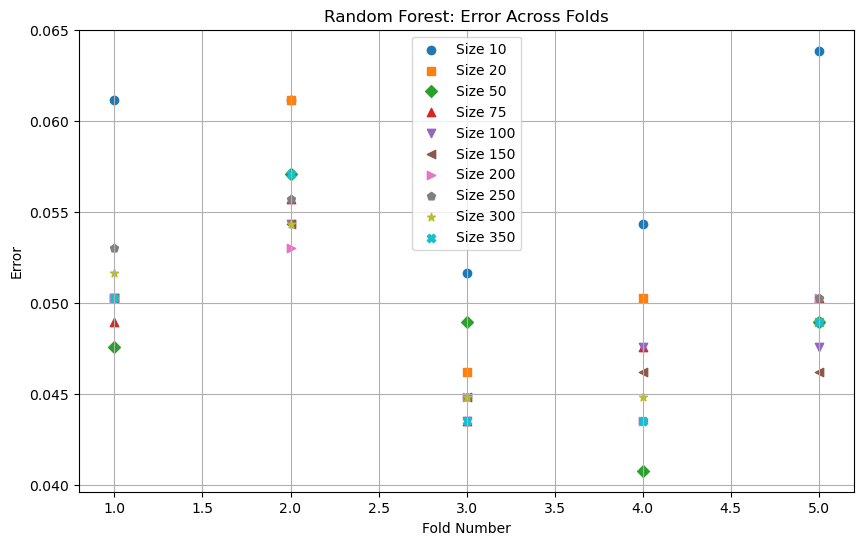


Best ensemble size for Random Forests: 150
Best average error for Random Forests: 0.0484


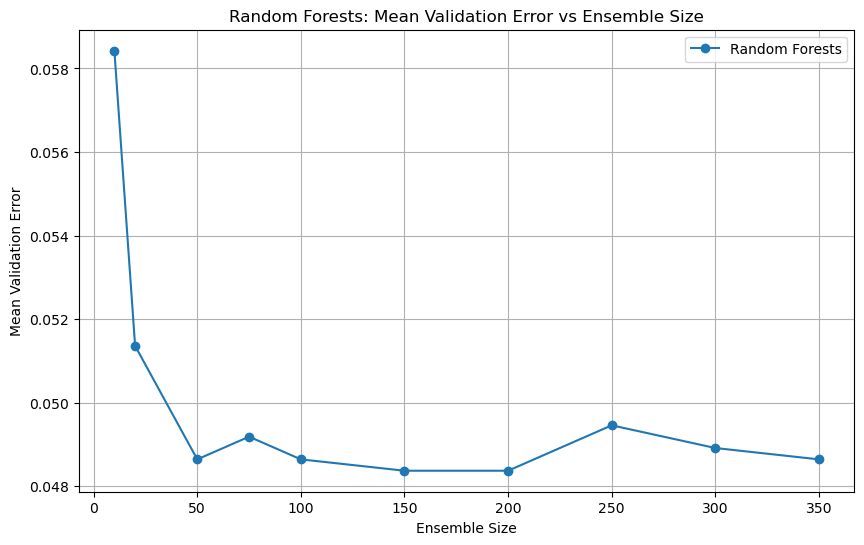

In [41]:
# 1. Random Forests: Tuning ensemble size
rf_ensemble_sizes = [10, 20, 50, 75, 100, 150, 200, 250, 300, 350]  # Sizes to try
rf_validation_scores = []  # Store mean validation error for each ensemble size
rf_fold_scores = {}  # Store fold-wise errors for each ensemble size

print("Tuning Random Forests...")
for size in rf_ensemble_sizes:
    # Define Random Forest with fixed hyperparameters
    rf_model = RandomForestClassifier(
        n_estimators=size,
        max_features=int(np.sqrt(X_train.shape[1])),  # d' = sqrt(d)
        criterion="gini",
        max_depth=None,
        random_state=random,
        bootstrap=True,
    )

    # Perform k-fold cross-validation
    val_score, fold_scores = k_fold_cross_validation(rf_model, X_train, y_train, k=5)
    rf_validation_scores.append(val_score)
    rf_fold_scores[size] = fold_scores

# Visualize Random Forest error across folds
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'X']  # List of markers
plt.figure(figsize=(10, 6))
for i, (size, errors) in enumerate(rf_fold_scores.items()):
    plt.scatter(range(1, 6), errors, label=f'Size {size}', marker=markers[i])  # Unique marker for each size
plt.xlabel('Fold Number')
plt.ylabel('Error')
plt.title('Random Forest: Error Across Folds')
plt.legend()
plt.grid(True)
plt.show()

# Select the best ensemble size for AdaBoost (lowest mean validation error)
min_error = min(rf_validation_scores)  # Find the minimum error
best_rf_indices = [i for i, error in enumerate(rf_validation_scores) if abs(error - min_error) < 1e-4]  # Tolerance threshold for nearly equal errors

# If multiple ensemble sizes are tied, select the smallest one
best_rf_index = min(best_rf_indices, key=lambda i: rf_ensemble_sizes[i])
best_rf_size = rf_ensemble_sizes[best_rf_index]  # Corresponding ensemble size
best_rf_error = rf_validation_scores[best_rf_index]  # Best average error

# Print the best results
print(f"\nBest ensemble size for Random Forests: {best_rf_size}")
print(f"Best average error for Random Forests: {best_rf_error:.4f}")

# Random Forest: Mean Validation Error vs Ensemble Size
plt.figure(figsize=(10, 6))
plt.plot(rf_ensemble_sizes, rf_validation_scores, label='Random Forests', marker='o')
plt.xlabel('Ensemble Size')
plt.ylabel('Mean Validation Error')
plt.title('Random Forests: Mean Validation Error vs Ensemble Size')
plt.legend()
plt.grid(True)
plt.show()

----
- **Tune AdaBoost by varying ensemble sizes**:
  - Test ensemble sizes: `[10, 20, 50, 75, 100, 150, 200, 250, 300, 350]`.

- **Initialize lists and dictionaries**:
  - `ada_validation_errors`: Stores mean validation errors for each ensemble size.
  - `ada_fold_errors`: Stores validation errors for each fold and ensemble size.

- **Loop over each ensemble size**:
  - Define an `AdaBoostClassifier` with:
    - A `DecisionTreeClassifier` (max_depth=1) as the weak learner (decision stumps).
    - The current ensemble size (`n_estimators`).
    - A fixed random seed for reproducibility.
  - Perform 5-fold cross-validation using the `k_fold_cross_validation` function.
  - Store mean validation errors and fold-specific errors.

- **Select the best ensemble size**:
  - Identify the ensemble size with the lowest mean validation error.
  - Print the best ensemble size and corresponding error.

- **Visualize errors across folds**:
  - Create a scatter plot showing validation errors for each fold and ensemble size.

- **Plot mean validation error vs. ensemble size**:
  - Create a line plot to show how mean validation error changes with ensemble size.

- **Train the best AdaBoost model**:
  - Use the best ensemble size on the full training dataset.
  - Evaluate the model on the test dataset and computes the test error.
  - Print the test error.

In [42]:
# 2. Boosted Decision Stumps: Tuning ensemble size
ada_ensemble_sizes = [10, 20, 50, 75, 100, 150, 200, 250, 300, 350]  # Sizes to try
ada_validation_errors = []  # Store mean validation error for each ensemble size
ada_fold_errors = {}  # Store fold-wise errors for each ensemble size

print("\nTuning AdaBoost...")
for size in ada_ensemble_sizes:
    # Define AdaBoost with weak learner as decision stumps
    ada_model = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1),  # Decision stumps
        n_estimators=size,
        random_state=random,
    )

    # Perform k-fold cross-validation
    mean_val_error, fold_errors = k_fold_cross_validation(ada_model, X_train, y_train, k=5)
    
    # Store results
    ada_validation_errors.append(mean_val_error)
    ada_fold_errors[size] = fold_errors

# Select the best ensemble size for AdaBoost (lowest mean validation error)
min_error = min(ada_validation_errors)  # Find the minimum error
best_ada_indices = [i for i, error in enumerate(ada_validation_errors) if abs(error - min_error) < 1e-4]  # Tolerance threshold for nearly equal errors

# If multiple ensemble sizes are tied, select the smallest one
best_ada_index = min(best_ada_indices, key=lambda i: ada_ensemble_sizes[i])
best_ada_size = ada_ensemble_sizes[best_ada_index]  # Corresponding ensemble size
best_ada_error = ada_validation_errors[best_ada_index]  # Best average error

# Print the best results
print(f"\nBest ensemble size for AdaBoost: {best_ada_size}")
print(f"Best average error for AdaBoost: {best_ada_error:.4f}")

# Visualize AdaBoost performance across folds
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'X']  # List of markers
plt.figure(figsize=(10, 6))
for i, (size, errors) in enumerate(ada_fold_errors.items()):
    plt.scatter(range(1, 6), errors, label=f'Size {size}', marker=markers[i])  # Unique marker for each size
plt.xlabel('Fold Number')
plt.ylabel('Error')
plt.title('AdaBoost: Error Across Folds')
plt.legend()
plt.grid(True)
plt.show()

# AdaBoost: Mean Validation Error vs Ensemble Size
plt.figure(figsize=(10, 6))
plt.plot(ada_ensemble_sizes, ada_validation_errors, label='AdaBoost', marker='o', color='orange')
plt.xlabel('Ensemble Size')
plt.ylabel('Mean Validation Error')
plt.title('AdaBoost: Mean Validation Error vs Ensemble Size')
plt.legend()
plt.grid(True)
plt.show()


Tuning AdaBoost...


KeyboardInterrupt: 

----
- **Train the final Random Forest model**:
  - Use the optimal ensemble size (`best_rf_size`) determined from tuning.
  - Train on the full training set (`X_train`, `y_train`).
  - Evaluate on the test set (`X_test`, `y_test`) and computes the test error.

- **Train the final AdaBoost model**:
  - Use the optimal ensemble size (`best_ada_size`) determined from tuning.
  - Use decision stumps (`max_depth=1`) as the weak learner.
  - Train on the full training set (`X_train`, `y_train`).
  - Evaluate on the test set (`X_test`, `y_test`) and computes the test error.

- **Output results**:
  - Print the test error for both Random Forests and AdaBoost.
  - Ensure the test set is used **only once** for final evaluation, following proper guidelines.

In [ ]:
# Train the final Random Forest model on the full training set
final_rf_model = RandomForestClassifier(
    n_estimators=best_rf_size,
    max_features=int(np.sqrt(X_train.shape[1])),
    criterion="gini",
    max_depth=None,
    random_state=random,
    bootstrap=True,
)
final_rf_model.fit(X_train, y_train)
rf_test_error = 1 - accuracy_score(y_test, final_rf_model.predict(X_test))
print(f"Test Error for Random Forests (size {best_rf_size}): {rf_test_error:.4f}")

# Train the best AdaBoost model on the full training set
best_ada_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),  # Decision stumps
    n_estimators=best_ada_size,
    random_state=random
)
best_ada_model.fit(X_train, y_train)
# Predict on the test set
y_test_pred = best_ada_model.predict(X_test)
# Compute test error
test_error = 1 - accuracy_score(y_test, y_test_pred)

# Output results
print(f"Test Error for Best AdaBoost Model (Size {best_ada_size}): {test_error:.4f}")

Test Error for Random Forests (size 200): 0.0543
Test Error for Best AdaBoost Model (Size 200): 0.0663
